In [1]:
import streamlit as st
import jsonlines
import random
import pandas as pd
import json
import fileinput
import numpy as np
from pprint import pprint
from wordcloud import WordCloud
from textblob_de import TextBlobDE as TextBlob
import re
import matplotlib.pyplot as plt

2022-06-02 20:40:10.144 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [2]:
#Importing Dataset
olafScholzJsonLines = jsonlines.open("OlafScholz.jl")

olafScholzTwitter = pd.read_json("OlafScholz.jl", lines = True)
print("Datensatzlänge: " + str(olafScholzTwitter.info()))

print(olafScholzTwitter.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   http_status   65 non-null     int64 
 1   account_name  65 non-null     object
 2   account_data  65 non-null     object
 3   params        65 non-null     object
 4   response      65 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.7+ KB
Datensatzlänge: None
   http_status account_name  \
0          200   OlafScholz   
1          200   OlafScholz   
2          200   OlafScholz   
3          200   OlafScholz   
4          200   OlafScholz   

                                        account_data  \
0  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
1  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
2  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
3  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
4  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   

         

In [3]:
# Reply Dataframe
# Importing Data into final Dataframe for ML
replyDataFrame = pd.DataFrame(columns = ["tweetid", "date", "time", "user", "text"])
print(replyDataFrame.head())
iterator = 0

for line in olafScholzJsonLines:
    keyResponse = line["response"]
    data = keyResponse["data"]
    newDataRow = [None, None, None, None, None]
    userName = line["account_name"]
    newDataRow[4] = userName
    keyResponse = line["response"]
    data = keyResponse["data"]


    for tweet in data:

        tweetTarget = 1
       
        tweetID = tweet["id"]
        authorID = tweet["author_id"]
        tweetDate = tweet["created_at"][0:10]
        tweetTime = tweet["created_at"][11:19]
        tweetText = tweet["text"]        
        newDataRow[0] = tweetID
        newDataRow[1] = tweetDate
        newDataRow[2] = tweetTime
        newDataRow[3] = authorID
        newDataRow[4] = tweetText
        replyDataFrame.loc[len(replyDataFrame)] = newDataRow
    iterator += 1


Empty DataFrame
Columns: [tweetid, date, time, user, text]
Index: []


In [4]:
#print(dir(replyDataFrame))
print(len(replyDataFrame))
print(replyDataFrame.shape)
print(replyDataFrame.head())

6419
(6419, 5)
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  RT @Bundeskanzler: Ich wünsche Ihnen und Ihren...  
1  RT @Bundeskanzler: Meine Solidarität gilt @Kar...  
2  RT @Bundeskanzler: Sie haben Hilfe organisiert...  
3  RT @Bundeskanzler: Verantwortung übernehmen he...  
4  RT @Bundeskanzler: Die Sanktionen gegen #Russl...  


In [5]:
print("----")
print(replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:")].sort_values("date",ascending = "true").head())

----
                tweetid        date      time      user  \
53  1493195813245313024  2022-02-14  12:09:58  38150247   
52  1493599012691365903  2022-02-15  14:52:09  38150247   
51  1493602211829587986  2022-02-15  15:04:51  38150247   
50  1494003008283287560  2022-02-16  17:37:29  38150247   
49  1494245849085493251  2022-02-17  09:42:26  38150247   

                                                 text  
53  RT @Bundeskanzler: Auf dem Weg in die #Ukraine...  
52  RT @Bundeskanzler: Der Frieden und die Sicherh...  
51  RT @Bundeskanzler: Ich habe Präsident #Putin i...  
50  RT @Bundeskanzler: Die #Corona-Regeln zeigen d...  
49  RT @Bundeskanzler: Gestern Abend habe ich mit ...  


In [6]:
#testing
print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").head())
print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").count())

0    True
1    True
2    True
3    True
4    True
Name: text, dtype: bool
6419


In [7]:
#cleansedTweetDF = replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:") or replyDataFrame["text"].str.contains("!RT @") ]
print("Size of dataframe :\n"+ str(replyDataFrame.count())+"\n----")
maskBundesKanz = replyDataFrame["text"].str.contains("RT @Bundeskanzler:")
maskNoRT = replyDataFrame["text"].str.contains("RT @")==False
print("Size of dataframe with RT @Bundeskanzler:\n" + str(replyDataFrame[maskBundesKanz].count())+"\n----")
print("Size of dataframe without RT @:\n" + str(replyDataFrame[maskNoRT].count())+"\n----")
#cleansedTweetDF contains all Tweets posted directly by Olaf before or after being Kanzler
cleansedTweetDF = replyDataFrame[maskBundesKanz | maskNoRT]
print("Size of cleansedTweetDF @:\n" + str(cleansedTweetDF.count())+"\n----")
print(cleansedTweetDF.head())
#cleansedTweetDF has "RT @Bundeskanzler:" still in the tweet. To not have any issues with ML we removed that part of the Tweet in the following parts

Size of dataframe :
tweetid    6419
date       6419
time       6419
user       6419
text       6419
dtype: int64
----
Size of dataframe with RT @Bundeskanzler:
tweetid    48
date       48
time       48
user       48
text       48
dtype: int64
----
Size of dataframe without RT @:
tweetid    4071
date       4071
time       4071
user       4071
text       4071
dtype: int64
----
Size of cleansedTweetDF @:
tweetid    4119
date       4119
time       4119
user       4119
text       4119
dtype: int64
----
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  RT @Bundeskanzler: Ich wünsche Ihnen und Ihren...  
1  RT @Bundeskanzler: Meine Solidaritä

In [8]:
# Removing the Text \"RT @Bundeskanzler:\" from the text\n
print("ReplyDataframe: \n" + str(replyDataFrame[maskBundesKanz].count()))
cleansedAtBundKanzDF = replyDataFrame[maskBundesKanz].copy()
cleansedAtBundKanzDF.text = cleansedAtBundKanzDF.text.str.strip("RT @Bundeskanzler: ")
print(cleansedAtBundKanzDF.head())                                                           

ReplyDataframe: 
tweetid    48
date       48
time       48
user       48
text       48
dtype: int64
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  Ich wünsche Ihnen und Ihren Familien frohe #Os...  
1  Meine Solidarität gilt @Karl_Lauterbach: Jeder...  
2  Sie haben Hilfe organisiert, Kräfte gebündelt ...  
3  Verantwortung übernehmen heißt: Deutschland li...  
4  Die Sanktionen gegen #Russland sind notwendig ...  


In [9]:
#appending the sliced versions to the Dataframe and resulting in the expected 4119 Tweets
cleansedTweetDFShort = replyDataFrame[maskNoRT].append(cleansedAtBundKanzDF)
print(cleansedTweetDFShort.count())
print(cleansedTweetDFShort.sort_values("date",ascending = False).head())

tweetid    4119
date       4119
time       4119
user       4119
text       4119
dtype: int64
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  Ich wünsche Ihnen und Ihren Familien frohe #Os...  
1  Meine Solidarität gilt @Karl_Lauterbach: Jeder...  
2  Sie haben Hilfe organisiert, Kräfte gebündelt ...  
3  Verantwortung übernehmen heißt: Deutschland li...  
4  Die Sanktionen gegen #Russland sind notwendig ...  


In [10]:
# Tobias 29.05.22 and 30.05.22

# Starting preparing for machine learning

# Making statement text in lower case

cleansedTweetDFShort

def clean(text):
    cleansedTweetDFShort['text'] = cleansedTweetDFShort['text'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
    text = re.sub(r'@[A-Za-z0-9]+\s?', '', text) #Removed Mentions
    text = re.sub(r'#', '', text) #Removed #
    text = re.sub(r'(.)1+', r'1', text) #cleaned single letters
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text) #Removes links
    text = re.sub('@','',text) #Remove @
    
    return text

cleansedTweetDFShort['text'] = cleansedTweetDFShort['text'].apply(clean)

cleansedTweetDFShort

,tweetid,date,time,user,text
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...
49,1494245849085493251,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situation...
50,1494003008283287560,2022-02-16,17:37:29,38150247,Die Corona-Regeln zeigen die erhoffte Wirkung....
51,1493602211829587986,2022-02-15,15:04:51,38150247,Ich habe Präsident Putin in Moskau verdeutlich...
52,1493599012691365903,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...


In [11]:
cleansedTweetDFShort = cleansedTweetDFShort.astype({'text':'string'})
print(cleansedTweetDFShort.dtypes)
cleansedTweetDFShort.head()

tweetid    object
date       object
time       object
user       object
text       string
dtype: object


,tweetid,date,time,user,text
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...


In [12]:
# Extra DF for wordcloud

cleansedTweetDFShort10 = cleansedTweetDFShort[:100].copy()
cleansedTweetDFShort10

,tweetid,date,time,user,text
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...
169,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jährt sich das Auffliegen des rechtsextr...
172,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank für das große Enga..."
174,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...
176,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank für die Einladung zum Kongress, un..."


In [13]:
#Get Polarity and Subjectivity

# Subjectivity quantifies the amount of personal opinion and factual information contained in the text. 
# The higher subjectivity means that the text contains personal opinion rather than factual information. 
# 0 means low personal opinion and 1 a lot of personal opinion

def getS (text):
    return TextBlob(text).sentiment.subjectivity

# Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.

def getP (text):
    return TextBlob(text).sentiment.polarity


cleansedTweetDFShort10['Personal Opinion (Subjectivity)'] = cleansedTweetDFShort10['text'].apply(getS)
cleansedTweetDFShort10['Sentiment (Polarity)'] = cleansedTweetDFShort10['text'].apply(getP)

cleansedTweetDFShort10

,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity)
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,0.000000,0.675000
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,0.000000,0.175000
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",0.000000,0.333333
55,1492074452796022791,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,0.000000,0.500000
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...,0.000000,0.350000
...,...,...,...,...,...,...,...
169,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jährt sich das Auffliegen des rechtsextr...,0.000000,-0.037500
172,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank für das große Enga...",0.250000,0.175000
174,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...,0.250000,0.000000
176,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank für die Einladung zum Kongress, un...",0.333333,0.333333


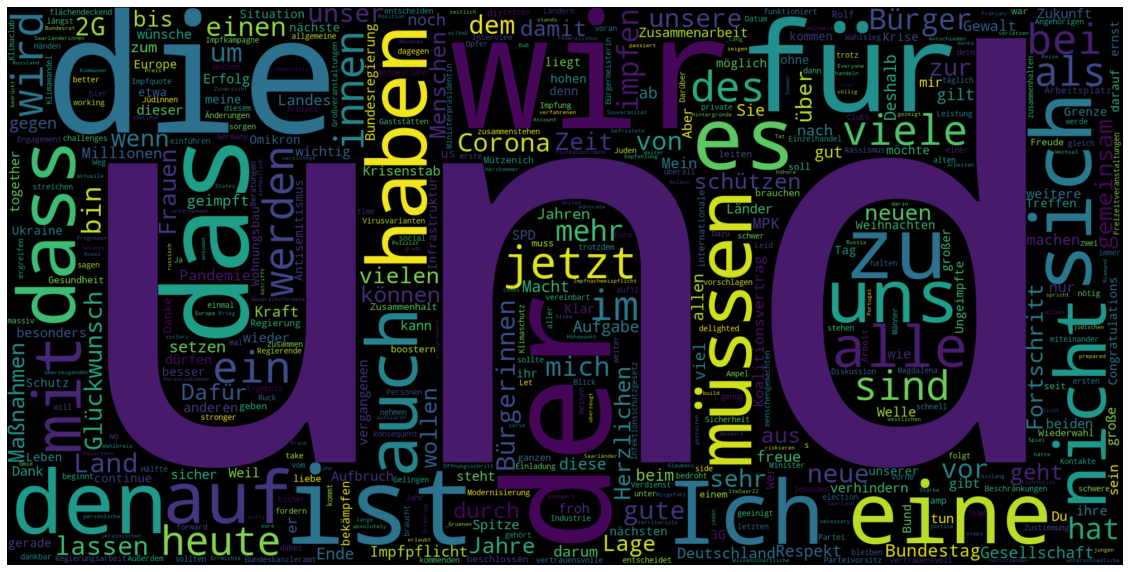

In [14]:
# Plot Word Cloud not cleaned

plt.figure(figsize = (20,20))

allWords = ' '.join([txt for txt in cleansedTweetDFShort10['text']])
wordCloud = WordCloud(max_words=500, width=2000, height = 1000, 
                      max_font_size = 1000, collocations=False).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [15]:
# Defining set containing all stopwords in German. (Stopwords: Word with no relevance for analysis)
# Source for Stopwordlist: https://github.com/stopwords-iso/stopwords-de/blob/master/stopwords-de.json
# Cleaning text from stopwords

# Create copy to work with
cleansedTweetDFShort10copy = cleansedTweetDFShort10.copy()

# Making statement text in lower case
cleansedTweetDFShort10copy['text']=cleansedTweetDFShort10copy['text'].str.lower()

with open('stopwords-de.json','r') as file:
    stopwordlistgerman = json.load(file)

STOPWORDS = set(stopwordlistgerman)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

cleansedTweetDFShort10copy['text'] = cleansedTweetDFShort10copy['text'].apply(lambda text: cleaning_stopwords(text))
cleansedTweetDFShort10copy['text'].head(10)

12    saarländerinnen saarländer klar wechsel spitze...
21    persönliche position längst bekannt: zeitlich ...
54    freue mich, folgt - alles, regierungsarbeit be...
55    aktuelle welle pandemie anlass zuversicht: wis...
56    corona-pandemie flutkatastrophe sommer gezeigt...
57    everyone can be absolutely sure that germany s...
60    stärke westlichen antwort lage russisch-ukrain...
61    verhindern, welle nächste folgt, virusvariante...
62    lage grenze ukraine ernst. klar ist: territori...
64    kusel passiert ist, bedrückt sehr. mitgefühl g...
Name: text, dtype: object

In [16]:
# Cleaning text from english stopwords
# Source for Stopwordlist: https://countwordsfree.com/stopwords
# Cleaning text from stopwords
with open('stop_words_english.json','r') as file:
    stopwordlistenglish = json.load(file)

STOPWORDS = set(stopwordlistenglish)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
cleansedTweetDFShort10copy['text'] = cleansedTweetDFShort10copy['text'].apply(lambda text: cleaning_stopwords(text))
cleansedTweetDFShort10copy['text'].head(10)

12    saarländerinnen saarländer klar wechsel spitze...
21    persönliche position längst bekannt: zeitlich ...
54    freue mich, folgt - alles, regierungsarbeit be...
55    aktuelle welle pandemie anlass zuversicht: wis...
56    corona-pandemie flutkatastrophe sommer gezeigt...
57    absolutely germany stands allies united russia...
60    stärke westlichen antwort lage russisch-ukrain...
61    verhindern, welle nächste folgt, virusvariante...
62    lage grenze ukraine ernst. klar ist: territori...
64    kusel passiert ist, bedrückt sehr. mitgefühl g...
Name: text, dtype: object

In [17]:
#Remove punctations

import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
cleansedTweetDFShort10copy['text']= cleansedTweetDFShort10copy['text'].apply(lambda x: cleaning_punctuations(x))
cleansedTweetDFShort10copy['text'].head(10)

12    saarländerinnen saarländer klar wechsel spitze...
21    persönliche position längst bekannt zeitlich b...
54    freue mich folgt  alles regierungsarbeit betri...
55    aktuelle welle pandemie anlass zuversicht wiss...
56    coronapandemie flutkatastrophe sommer gezeigt ...
57    absolutely germany stands allies united russia...
60    stärke westlichen antwort lage russischukraini...
61    verhindern welle nächste folgt virusvarianten ...
62    lage grenze ukraine ernst klar ist territorial...
64    kusel passiert ist bedrückt sehr mitgefühl gil...
Name: text, dtype: object

In [22]:
# Applying Stemming

import nltk
from nltk.stem import PorterStemmer
 
porter = PorterStemmer()

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
cleansedTweetDFShort10copy['text']= cleansedTweetDFShort10copy['text'].apply(lambda x: stemming_on_text(x))

In [27]:
 
def stemming_on_text(data):
    text = [porter.stem(word) for word in data]
    return data
cleansedTweetDFShort10copy['text']= cleansedTweetDFShort10copy['text'].apply(lambda x: stemming_on_text(x))


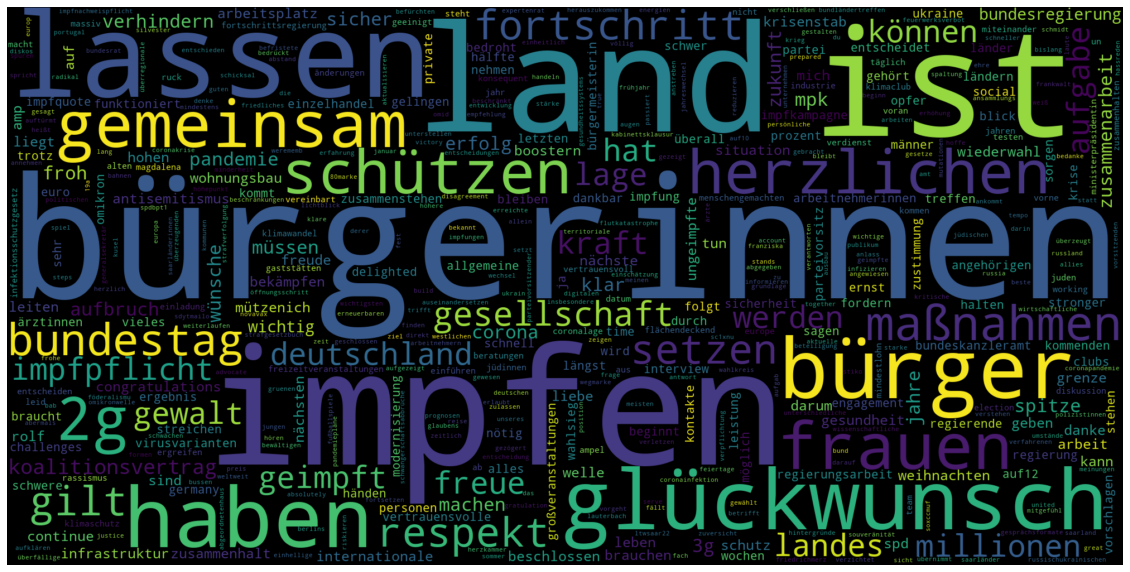

In [28]:
# Plot Word Cloud after cleaning
plt.figure(figsize = (20,20))
cleanedwords = ' '.join([txt for txt in cleansedTweetDFShort10copy['text']])
wordCloud = WordCloud(max_words = 500, width=2000, height = 1000, max_font_size = 1000, 
                      collocations=False).generate(cleanedwords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [ ]:
# Sentiment Analysis with TextBlob 

# Create a function to compute analysis

def getA(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

cleansedTweetDFShort10['Analysis'] = cleansedTweetDFShort10['Sentiment (Polarity)'].apply(getA)
cleansedTweetDFShort10

In [ ]:
sortedDf = cleansedTweetDFShort10.sort_values(by=['Sentiment (Polarity)'])

#sortedDf = sortedDf.astype({'Analysis':'string'})
print(sortedDf.dtypes)
sortedDf.reset_index(inplace=True, drop=True) # Reset index
sortedDf.head()

In [ ]:
# Show texts with Polarity and Analysis 

# Problem erkannt: Er schreibt sowohl englisch als auch deutsch

sortedDf

for i in range (0, sortedDf.shape[0]):
    print(sortedDf['text'][i])
    print(sortedDf['Personal Opinion (Subjectivity)'][i])
    print(sortedDf['Sentiment (Polarity)'][i])
    print(sortedDf['Analysis'][i])
    print()

In [ ]:
# Print Positive tweets

j=1;

for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'positive'):
        print(str(j) + ') ' + sortedDf['text'][i])
        print(sortedDf['Personal Opinion (Subjectivity)'][i])
        print(sortedDf['Sentiment (Polarity)'][i])
        print(sortedDf['Analysis'][i])
        print()
        j=j+1

In [ ]:
# Print Negative tweets

j=1;

for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'negative'):
        print(str(j) + ') ' + sortedDf['text'][i])
        print(sortedDf['Personal Opinion (Subjectivity)'][i])
        print(sortedDf['Sentiment (Polarity)'][i])
        print(sortedDf['Analysis'][i])
        print()
        j=j+1

In [ ]:
#Plot polarity and subjectivity

plt.figure(figsize=(8,6))

for i in range (0, sortedDf.shape[0]):
    plt.scatter(sortedDf['Sentiment (Polarity)'][i], sortedDf['Personal Opinion (Subjectivity)'][i], color='Green')
                
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
# Get the percentage of positive tweets

ptweets = sortedDf[sortedDf.Analysis =="positive"] 

print("Positive Tweets in percent: "+str(round((ptweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

In [ ]:
# Get the negative of positive tweets

neutweets = sortedDf[sortedDf.Analysis =="neutral"] 

print("Neutral Tweets in percent: "+str(round((neutweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

In [ ]:
# Get the negative of positive tweets

ntweets = sortedDf[sortedDf.Analysis =="negative"] 

print("Negative Tweets in percent: "+str(round((ntweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

In [ ]:
# Show Analysis

sortedDf['Analysis'].value_counts()

plt.title('Sentiment Analysis in %')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
sortedDf['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
# Test of spelling correction

